# Петров, Попов 6411
## Дифференциальное кодировние

In [27]:
from matplotlib import pyplot as plt
import numpy as np
import skimage.io
from skimage import img_as_float
from skimage import exposure

def entropy(arr):
    _, counts = np.unique(arr, return_counts=True)
    counts = counts / counts.sum()
    return -(counts * np.log2(counts)).sum()

def pred1(i, j, img):
    if i == 0 and j == 0:
        return 0
    if j == 0:
        return img[i - 1][-1]
    return img[i][j - 1]

def pred2(i, j, img):
    if i == 0 or j == 0:
        return 0
    return int((img[i][j - 1] + img[i - 1][j]) / 2)

def MyDifCode(x, e, pred):
    f = np.zeros(x.shape)
    y = np.zeros(x.shape)
    q = np.zeros(x.shape)

    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            p = pred(i, j, y)
            f[i][j] = x[i][j] - p
            q[i][j] = np.sign(f[i][j]) * ((abs(f[i][j]) + e) // (2 * e + 1))
            y[i][j] = p + q[i][j] * (2 * e + 1)
            if abs(y[i][j] - x[i][j]) > e:
                raise Exception("Не выполняется условие макс.ошибки!!!")

    return q, f


def MyDifDeCode(q, e, pred):
    y = np.zeros(q.shape)

    for i in range(q.shape[0]):
        for j in range(q.shape[1]):
            p = pred(i, j, y)
            y[i][j] = p + q[i][j] * (2 * e + 1)
            
    return y

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    # Преобразование изображения в формат с плавающей запятой двойной точности
    image = img_as_float(image)
    ax_img, ax_hist = axes
    # Создайте новые оси с невидимой осью X и независимой осью Y.
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)

    # Display histogram
    ax_hist.hist(image.flatten(), bins=bins, histtype='step', color='black')
    ax_hist.set_xlabel('Pixel intensity',fontsize=25)
    ax_hist.tick_params(axis="x", labelsize=20)
    ax_hist.tick_params(axis="y", labelsize=20)
    
    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')

    return ax_img, ax_hist, ax_cdf

In [8]:
img = plt.imread("01_apc.tif")

### График зависимости энтропии массива q (оценка объёма сжатых данных) от максимальной погрешности e двух предсказателей

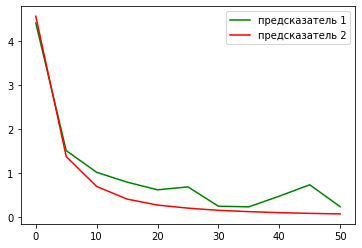

In [9]:
x = range(0, 51, 5)
y1 = [entropy(MyDifCode(img, e, pred1)[0]) for e in x]
y2 = [entropy(MyDifCode(img, e, pred2)[0]) for e in x]
plt.plot(x, y1, color="g", label="предсказатель 1")
plt.plot(x, y2, color="r", label="предсказатель 2")
plt.legend()
plt.show()

### Декомпрессированные изображения для e=5, e=10, e=20, e=40

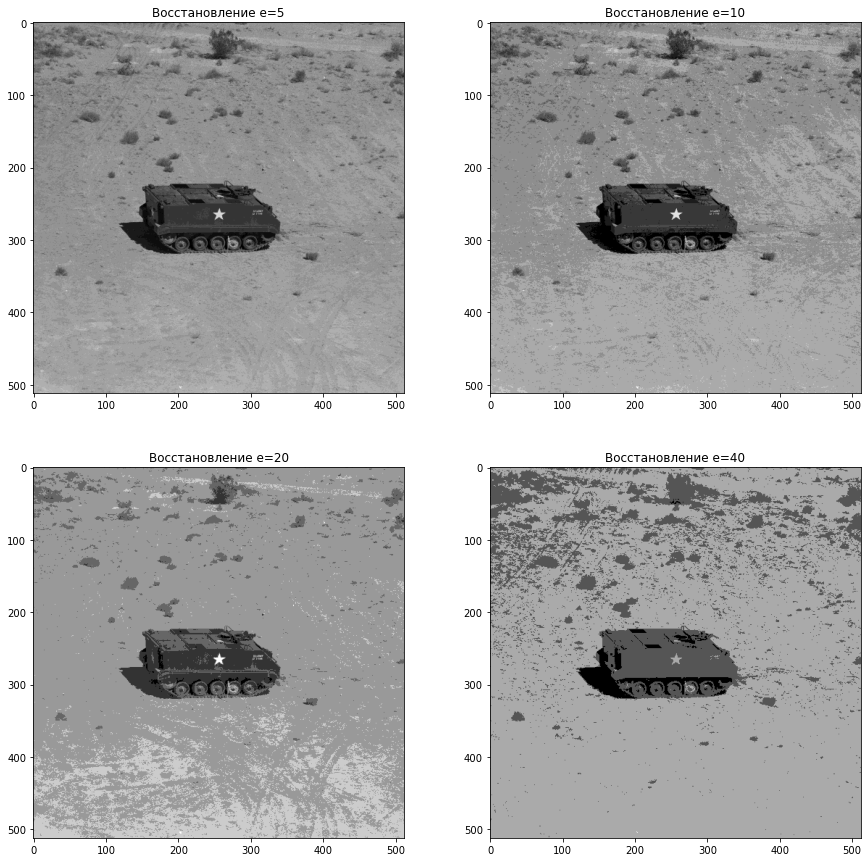

In [10]:
e = [5, 10, 20, 40]
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

for i in range(4):
    q, _ = MyDifCode(img, e[i], pred1)
    y = MyDifDeCode(q, e[i], pred1)
    axes[i].imshow(y, cmap="gray")
    axes[i].set_title(f"Восстановление e={e[i]}")

### Разностный сигнал при e=0 и квантованный разностный сигнал  для e=0 e=5 и e=10

D:\Programs\Anaconda\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


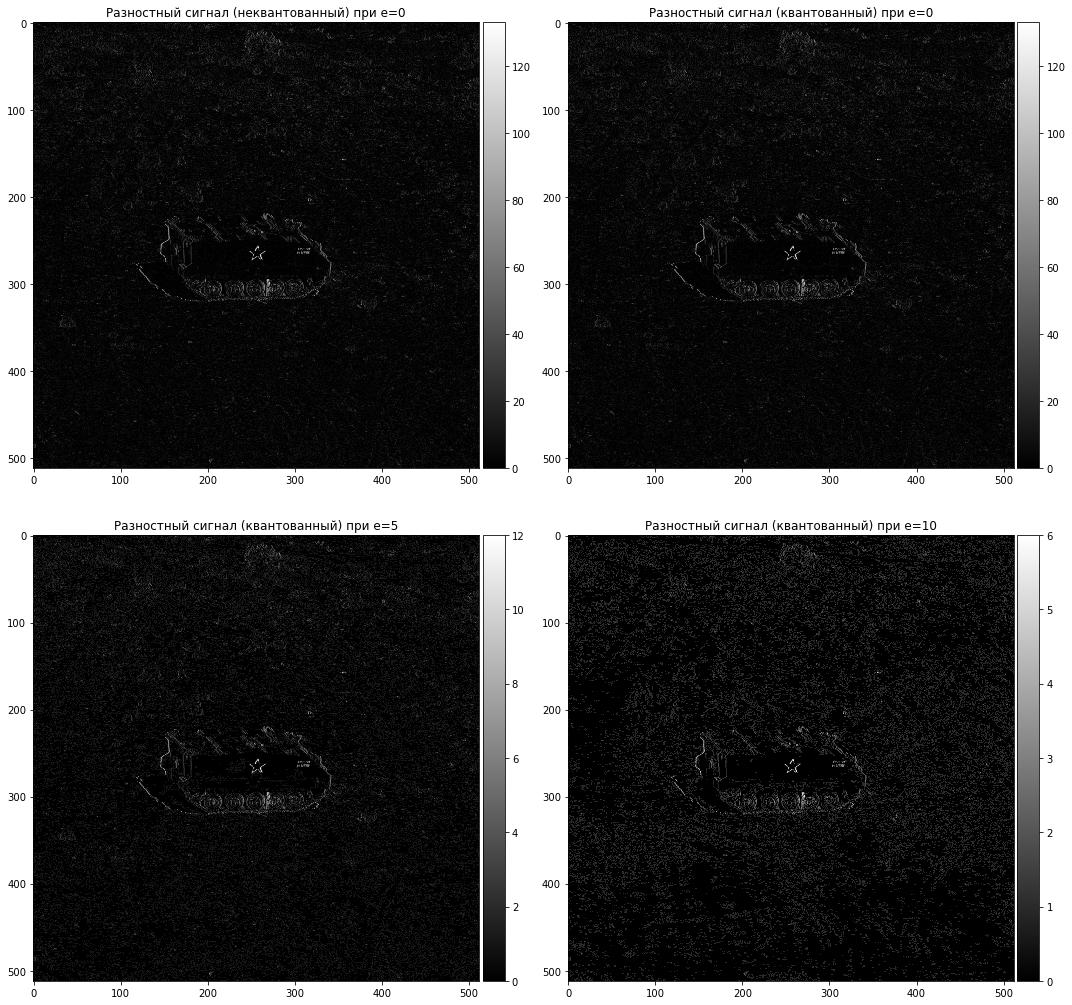

In [31]:
e = [0, 0, 5, 10]
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

for i in range(4):
    q, f = MyDifCode(img, e[i], pred1)

    if i == 0:
        s = f
        desc = "неквантованный"
    else:
        s = q
        desc = "квантованный"

    skimage.io.imshow(abs(s), cmap="gray", ax=axes[i])
    axes[i].set_title(f"Разностный сигнал ({desc}) при e={e[i]}")